In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import squarify
import seaborn as sns

In [2]:
# Load the data
filepath = 'processed_data.csv'  # Replace with the actual file path
df = pd.read_csv(filepath)

In [3]:
# Inspect the data
print(df.shape)
print(df.columns)
df.head(10)

(193, 2)
Index(['Company', 'Industry'], dtype='object')


,Company,Industry
0,#67,Telephone Utilities
1,46andMix,Other
2,A_Connect,Education
3,AA,Computer Software
4,Abstract,Internet
5,Adonis,Health
6,Ahonetwo,Business Services
7,AI HR APP,Computer Software
8,AIID,"Builders/Residential, Computer Software"
9,ANAKIN,Internet


In [4]:
df.describe()

,Company,Industry
count,193,193
unique,193,72
top,#67,Other
freq,1,32


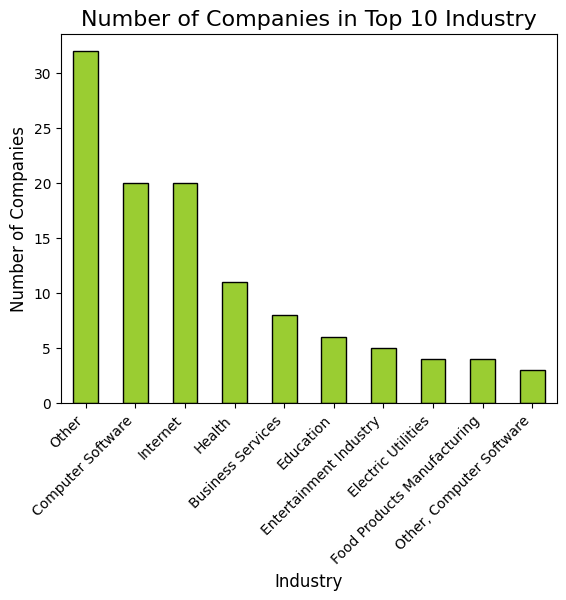

In [5]:
# Bar chart showing the number of companies in top 10 industry
industry_counts_top10 = df['Industry'].value_counts().head(10)
industry_counts_top10.plot(kind='bar', color='yellowgreen', edgecolor='black')
plt.title('Number of Companies in Top 10 Industry', fontsize=16)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Number of Companies', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

Text(0, 0.5, '')

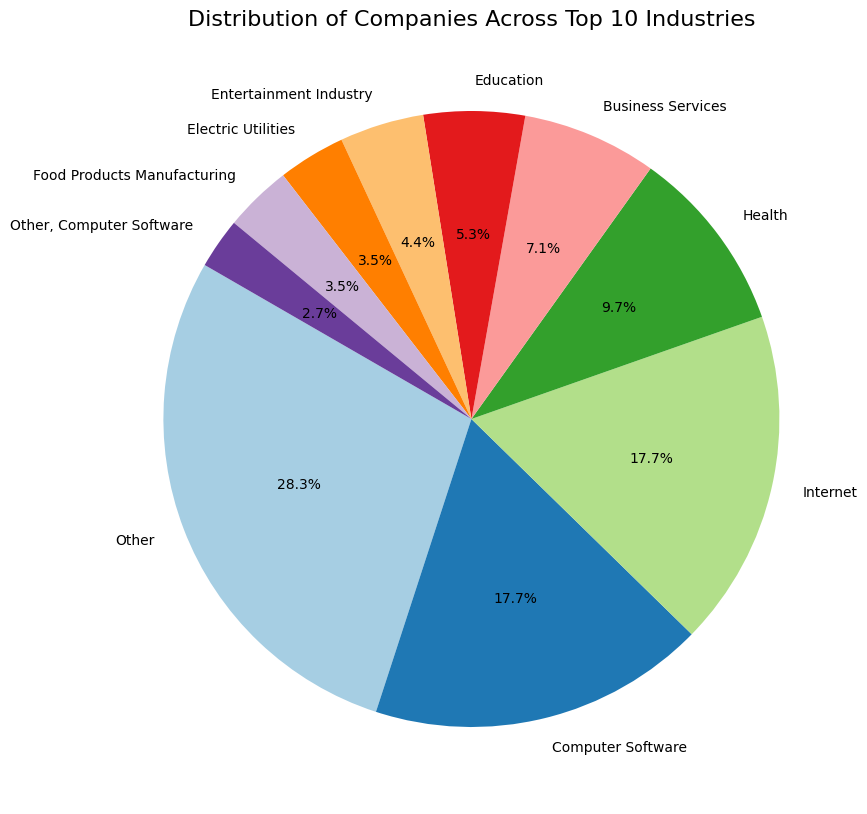

In [6]:
# Pie Chart: Percentage Distribution of Companies Across Industries
plt.figure(figsize=(10, 10))
industry_counts_top10.plot(kind='pie', autopct='%1.1f%%', startangle=150, colors=plt.cm.Paired.colors)
plt.title('Distribution of Companies Across Top 10 Industries', fontsize=16)
plt.ylabel('')  # Hides the y-label for the pie chart

In [7]:
import networkx as nx
from collections import defaultdict

In [8]:
def create_industry_network():
    G = nx.Graph()
    industry_connections = defaultdict(int)

    for _, row in df.iterrows():
        industries = [ind.strip() for ind in row['Industry'].split(',')]
        if len(industries) > 1:
            for i in range(len(industries)):
                for j in range(i + 1, len(industries)):
                    pair = tuple(sorted([industries[i], industries[j]]))
                    industry_connections[pair] += 1

    unique_industries = set()
    for pair in industry_connections:
        unique_industries.add(pair[0])
        unique_industries.add(pair[1])

    for industry in unique_industries:
        company_count = df['Industry'].str.contains(industry).sum()
        G.add_node(industry, size=company_count)

    for (ind1, ind2), weight in industry_connections.items():
        G.add_edge(ind1, ind2, weight=weight)

    return G

In [9]:
def adjust_positions(pos, min_dist=1, max_iterations=50):
    pos_array = np.array([pos[node] for node in pos])

    adjusted = True
    iteration = 0

    while adjusted and iteration < max_iterations:
        iteration += 1
        adjusted = False
        dx = pos_array[:, 0, np.newaxis] - pos_array[:, 0]
        dy = pos_array[:, 1, np.newaxis] - pos_array[:, 1]
        dist = np.sqrt(dx**2 + dy**2)

        np.fill_diagonal(dist, np.inf)

        close_pairs = dist < min_dist

        for i, j in zip(*np.where(close_pairs)):
            if i < j:
                factor = (min_dist - dist[i, j]) / dist[i, j]
                dx_ij, dy_ij = dx[i, j], dy[i, j]
                pos_array[i, 0] += dx_ij * factor
                pos_array[i, 1] += dy_ij * factor
                pos_array[j, 0] -= dx_ij * factor
                pos_array[j, 1] -= dy_ij * factor
                adjusted = True

    new_pos = {node: pos_array[i] for i, node in enumerate(pos)}
    return new_pos


In [10]:
def draw_network(G, save_pos_file='node_positions.npy', loading_existing=False):
    np.random.seed(42)

    # Create figure
    plt.figure(figsize=(17, 17))

    pos = nx.spring_layout(G, k=2, iterations=100, seed=42)

    pos = adjust_positions(pos)

    if loading_existing and os.path.exists(save_pos_file):
        pos = np.load(save_pos_file, allow_pickle=True).item()
    else:
        pos = nx.spring_layout(G, k=2, iterations=100, seed=42)
        np.save(save_pos_file, pos)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.4, edge_color='olive')

    # Draw nodes
    node_sizes = [G.nodes[node]['size'] * 200 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='gold', alpha=0.7)

    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=13)

    # Add title and remove axes
    plt.title('Industry Relationship Network', fontsize=20)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

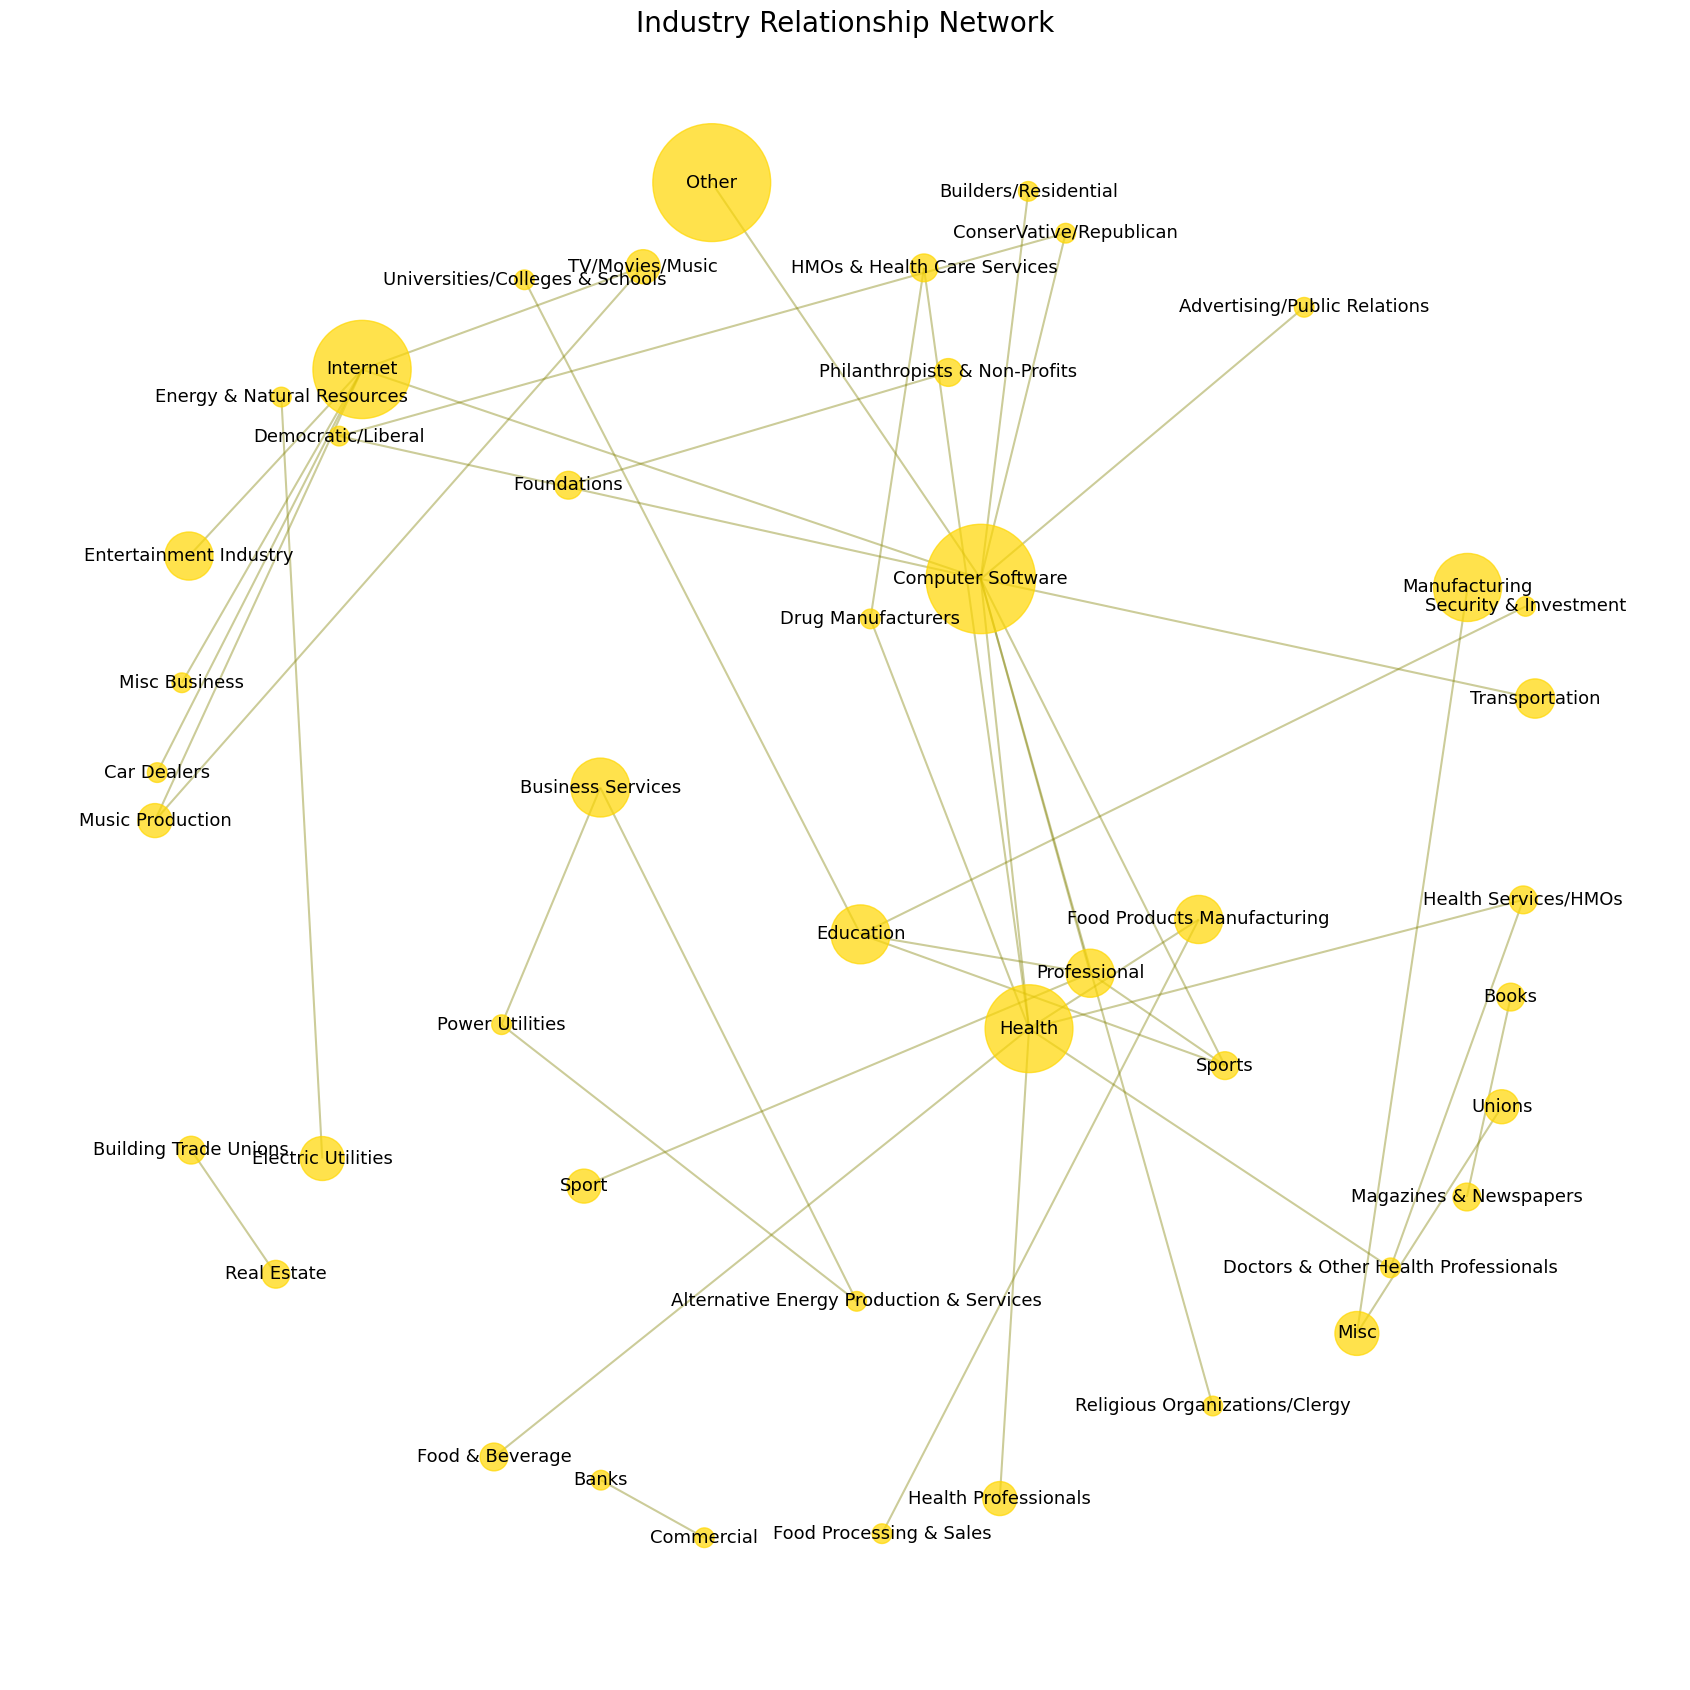

In [11]:
# Create and visualize the network
G = create_industry_network()
draw_network(G)

In [12]:
from wordcloud import WordCloud
from collections import Counter

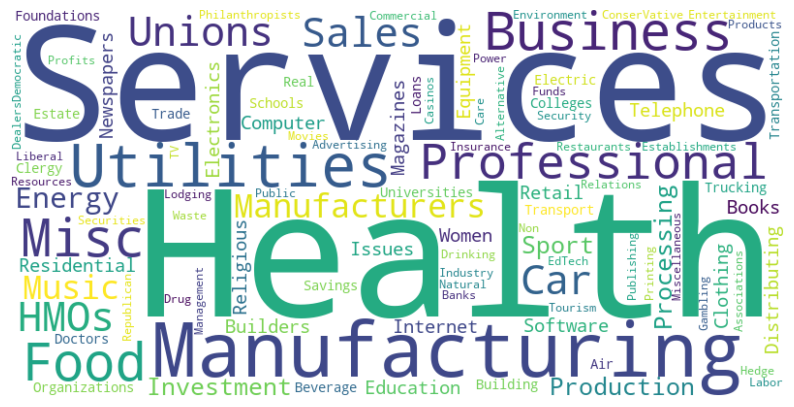

In [13]:
# Process industries
# Split industries that have multiple categories and create a flat list
all_industries = []
for industries in df['Industry'].str.split(','):
    all_industries.extend([industry.strip() for industry in industries])

# Count frequencies
industry_freq = Counter(all_industries)

# Create text for wordcloud (repeat words based on frequency)
text = ' '.join([industry + ' ' * count for industry, count in industry_freq.items()])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis_r').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [3]:
import plotly as plotly
import plotly.express as px
import plotly.graph_objects as go

In [15]:
# Check and preprocess the data
df['Industry'] = df['Industry'].str.split(',')
df['Company'] = df['Company'].str.split(',')

# Prepare data for the Sunburst chart
sunburst_data = []
for _, row in df.iterrows():
    industries = row['Industry']
    for i, industry in enumerate(industries):
        parent = industries[i - 1] if i > 0 else "All Industries"
        sunburst_data.append({"ids": industry.strip(), "labels": industry.strip(), "parents": parent.strip(), "values": 1})

# Create DataFrame for sunburst
sunburst_df = pd.DataFrame(sunburst_data)

In [16]:
fig = px.sunburst(
    sunburst_df,
    path=['parents', 'labels'],
    values='values',
    color='labels',
    color_discrete_sequence=px.colors.qualitative.Set2_r,  # Better for categorical data
)

fig.update_traces(insidetextorientation='radial',
                  textinfo='label')

fig.update_layout(
    title={
        'text': 'Sunburst Chart of Industry Relationships',
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 25, 'color': 'black'}
    },
    margin=dict(t=90, l=10, r=10, b=10),
    width=1500,
    height=1300
)

fig.show()

The 'textinfo' property is a flaglist and may be specified
    as a string containing:
      - Any combination of ['label', 'text', 'value', 'current path', 'percent root', 'percent entry', 'percent parent'] joined with '+' characters
        (e.g. 'label+text')
        OR exactly one of ['none'] (e.g. 'none')

In [17]:
plotly.offline.plot(fig, filename='E:/Desktop/Uni/Career/Jobs/Forkaia/Forkaia/task10/sunburst.html')

'E:/Desktop/Uni/Career/Jobs/Forkaia/Forkaia/task10/sunburst.html'

In [4]:
# Create treemap data structure
treemap_data = []
for _, row in df.iterrows():
    industries_treemap = [ind.strip() for ind in row['Industry'].split(',') if ind.strip()]

    primary_industry = industries_treemap[0] if len(industries_treemap) > 0 else 'No Primary Industry'
    secondary_industry = industries_treemap[1] if len(industries_treemap) > 1 else 'No Secondary Industry'
    tertiary_industry = industries_treemap[2] if len(industries_treemap) > 2 else 'No Tertiary Industry'

    treemap_data.append({
        'Primary Industry': primary_industry,
        'Secondary Industry': secondary_industry,
        'Tertiary Industry': tertiary_industry,
        'Company': row['Company'],
        'Value': 1  # Equal size for all companies
    })

# Create DataFrame
treemap_df = pd.DataFrame(treemap_data)

# Replace None values with empty strings
treemap_df = treemap_df.fillna('No Data')

In [5]:
treemap_df[:30]

,Primary Industry,Secondary Industry,Tertiary Industry,Company,Value
0,Telephone Utilities,No Secondary Industry,No Tertiary Industry,#67,1
1,Other,No Secondary Industry,No Tertiary Industry,46andMix,1
2,Education,No Secondary Industry,No Tertiary Industry,A_Connect,1
3,Computer Software,No Secondary Industry,No Tertiary Industry,AA,1
4,Internet,No Secondary Industry,No Tertiary Industry,Abstract,1
5,Health,No Secondary Industry,No Tertiary Industry,Adonis,1
6,Business Services,No Secondary Industry,No Tertiary Industry,Ahonetwo,1
7,Computer Software,No Secondary Industry,No Tertiary Industry,AI HR APP,1
8,Builders/Residential,Computer Software,No Tertiary Industry,AIID,1
9,Internet,No Secondary Industry,No Tertiary Industry,ANAKIN,1


In [6]:
# Generate treemap
fig = px.treemap(
    treemap_df,
    path=[
        px.Constant('All Industries'),  # Add a root level for better visualization
        'Primary Industry',
        'Secondary Industry',
        'Tertiary Industry',
        'Company'
    ],
    color_discrete_sequence=px.colors.qualitative.Set2,
    title='Hierarchy of Industries and Startups'
)

fig.update_layout(
    width=2000,
    height=1800,
    title_x=0.5,
    title_font_size=24,
    autosize=True
)

fig.show()

In [ ]:
plotly.io.write_image(fig, 'treemap.pdf', format='pdf')